<a href="https://colab.research.google.com/github/gumdropsteve/special_topics_week/blob/main/day_04/02_meta_ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install category-encoders

# Standard Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce

# Classifiers to Use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Other needed imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = sns.load_dataset("titanic").drop(["who", "adult_male", "alive","alone"], axis=1)
print(df.shape)
df.head()

(891, 11)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town
0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton
1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg
2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton
3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton
4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton


In [ ]:
# Change columns to strings so they will be one hot encoded later on
df["pclass"] = df["pclass"].astype("str")
df["parch"] = df["parch"].astype("str")
df["sibsp"] = df["sibsp"].astype("str")

# Scale continuous features and replace in the original df
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[["age", "fare"]]), columns=["age", "fare"])
df["age"] = scaled_df["age"]
df["fare"] = scaled_df["fare"]

# Total columns to be created
df.describe(exclude="number").T["unique"].sum()

35

In [ ]:
# Create a dictionary holding all Classifiers and preprocessing techniques
models = {
    "lr": make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),LogisticRegression()),
    "knn": make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),KNeighborsClassifier()),
    "dt": make_pipeline(ce.OneHotEncoder(),SimpleImputer(strategy="median") ,DecisionTreeClassifier())
}

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=9000)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# Split data
X = df.drop("survived", axis=1)
y = df["survived"]

# Baseline Score
print("Model Baseline")
df["survived"].value_counts(normalize=True)[0]

Model Baseline


0.6161616161616161

In [ ]:
# Evaluate models on their own

result_ls = []
model_ls = []

# Iterate over models dict and evaluate each seprately
for key, value in models.items():

    # gather scores KFold cross validation scores
    score = evaluate_model(value, X, y)
    result_ls.append(score) # save results
    model_ls.append(key) # save model name
    print(f"Model: {key}, Score: {np.mean(score)}")

Model: lr, Score: 0.8136934279078526
Model: knn, Score: 0.7945985813822107
Model: dt, Score: 0.7873014876655577


#### Looking at our crossval score boxplots we can see that all models are performing pretty much the same. Lets see if we can do better with model stacking

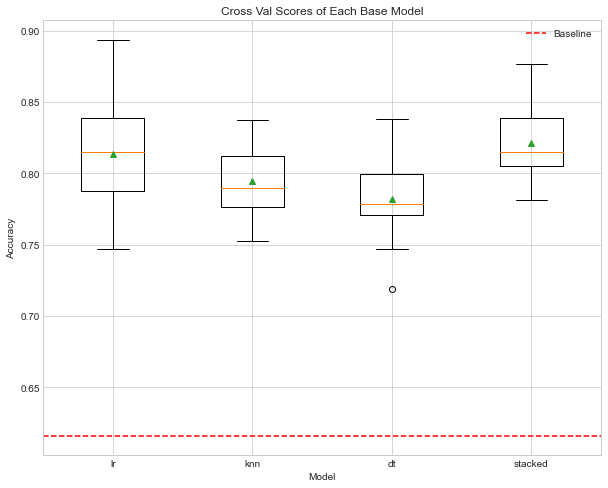

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.title("Cross Val Scores of Each Base Model")
plt.xlabel("Model")
plt.axhline(0.6161616161616161, linestyle="--", c="r", label="Baseline")
plt.legend()
plt.ylabel("Accuracy");

[Stacking Classifier Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [ ]:
# Stacking Classifier is expecting a list
stack_ls = [
            ("lr", make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),LogisticRegression())),
            ("knn", make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),KNeighborsClassifier())),
            ("dt", make_pipeline(ce.OneHotEncoder(),SimpleImputer(strategy="median") ,DecisionTreeClassifier()))
            ]

# Create Stacked Classifier
stack_model = StackingClassifier(stack_ls, cv=5)

# Add stack_model to models dictionary
models["stacked"] = stack_model

In [ ]:
# Evaluate All Models
result_ls = []
model_ls = []

# Iterate over models dict and evaluate each seprately
for key, value in models.items():

    # gather scores KFold cross validation scores
    score = evaluate_model(value, X, y)
    result_ls.append(score) # save results
    model_ls.append(key) # save model name
    print(f"Model: {key}, Score: {np.mean(score)}")

Model: lr, Score: 0.8136934279078526
Model: knn, Score: 0.7945985813822107
Model: dt, Score: 0.7822358922854812
Model: stacked, Score: 0.821539765237587


#### In this case our stacked estimator performed better than all base estimators so it is better to use the stacked estimator. If your stacked estimator does not perform better than one of your base estimators then it will be better to use the better performing base estimator

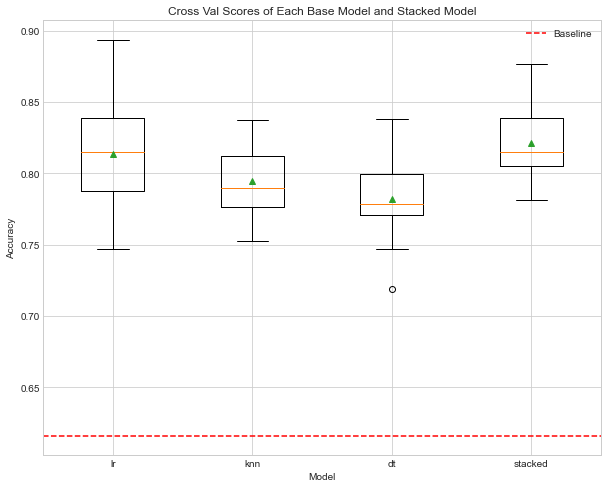

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.title("Cross Val Scores of Each Base Model and Stacked Model")
plt.xlabel("Model")
plt.axhline(0.6161616161616161, linestyle="--", c="r", label="Baseline")
plt.legend()
plt.ylabel("Accuracy");

Grid Search

In [ ]:
param_grid = {
    "dt__onehotencoder__drop_invariant": [True, False],
    "dt__simpleimputer__strategy": ["mean", "median"],
    "dt__decisiontreeclassifier__criterion": ["gini", "entropy"],
    "dt__decisiontreeclassifier__splitter": ["best", "random"],
    "dt__decisiontreeclassifier__max_depth": [None, 2],
    "dt__decisiontreeclassifier__ccp_alpha": [0.0,0.030],
    "lr__onehotencoder__drop_invariant": [True, False],
    "lr__simpleimputer__strategy": ["mean", "median"],
    "lr__logisticregression__solver": ["lbfgs", "liblinear"],
    "knn__onehotencoder__drop_invariant": [True, False],
    "knn__kneighborsclassifier__n_neighbors": [5,10],
    "knn__kneighborsclassifier__metric": ["minkowski", "euclidean"],
}

grid_model = GridSearchCV(stack_model, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)

grid_model.fit(X,y)

Fitting 5 folds for each of 4096 candidates, totalling 20480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 66.7min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 79.9min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 95.4min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 111.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 129.3min
[Parallel(n_jobs=-1)]: Done 9097 tasks      |

GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('lr',
                                                       Pipeline(steps=[('onehotencoder',
                                                                        OneHotEncoder()),
                                                                       ('simpleimputer',
                                                                        SimpleImputer(strategy='median')),
                                                                       ('logisticregression',
                                                                        LogisticRegression())])),
                                                      ('knn',
                                                       Pipeline(steps=[('onehotencoder',
                                                                        OneHotEncoder()),
                                                                

In [ ]:
grid_model.best_score_

0.8283095850856819

In [ ]:
grid_model.best_params_

{'dt__decisiontreeclassifier__ccp_alpha': 0.0,
 'dt__decisiontreeclassifier__criterion': 'entropy',
 'dt__decisiontreeclassifier__max_depth': None,
 'dt__decisiontreeclassifier__splitter': 'best',
 'dt__onehotencoder__drop_invariant': True,
 'dt__simpleimputer__strategy': 'mean',
 'knn__kneighborsclassifier__metric': 'euclidean',
 'knn__kneighborsclassifier__n_neighbors': 5,
 'knn__onehotencoder__drop_invariant': False,
 'lr__logisticregression__solver': 'liblinear',
 'lr__onehotencoder__drop_invariant': True,
 'lr__simpleimputer__strategy': 'mean'}

In [ ]:
# Pull out best model CV results to plot alongside all models tested
grid_df = pd.DataFrame(grid_model.cv_results_)
grid_cv_score_best = grid_df[grid_df["rank_test_score"]==1].loc[:,"split0_test_score":"split4_test_score"].T[1068].values

In [ ]:
# Add results to running list of other model scores
result_ls.append(grid_cv_score_best)
model_ls.append("grid")

<Figure size 800x550 with 0 Axes>

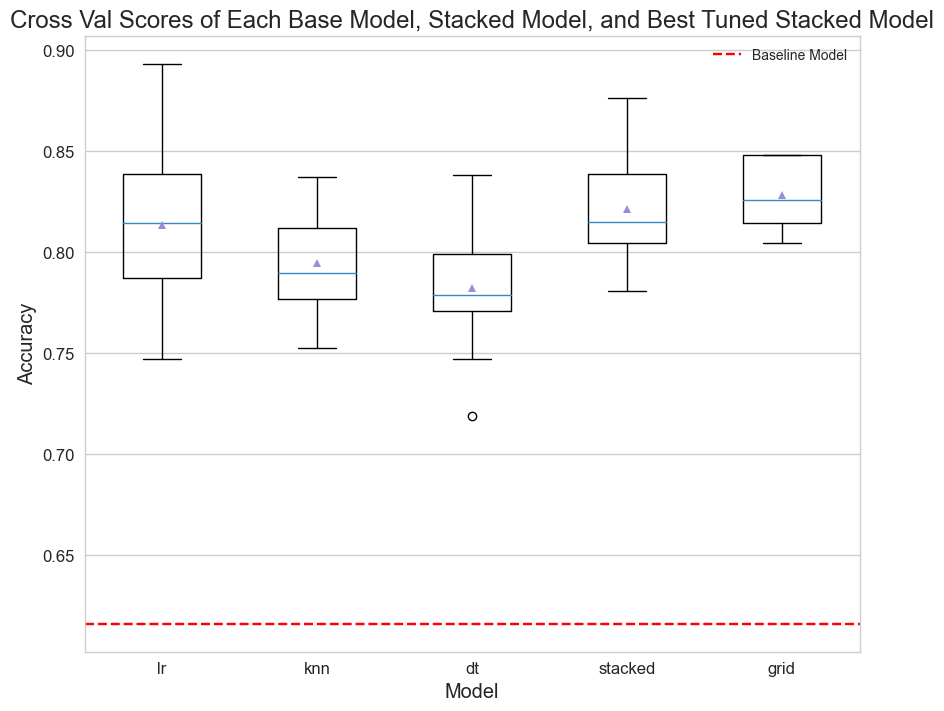

In [ ]:
# plot results
plt.style.use("seaborn-whitegrid")
plt.tight_layout()
plt.figure(figsize=(10,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.title("Cross Val Scores of Each Base Model, Stacked Model, and Best Tuned Stacked Model", fontsize="xx-large")
plt.xlabel("Model", fontsize="x-large")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.axhline(0.6161616161616161, linestyle="--", c="r", label="Baseline Model")
plt.legend()
plt.ylabel("Accuracy", fontsize="x-large")
plt.grid(b=None, axis="x")
plt.savefig("compare_model.png", dpi=150);